# Cryptolytic Arbitrage Model Evaluation and Selection

This notebook contains the code and analysis to select models with the best performance for the Cryptolytic project. You can find more information on data processing in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_data_processing.ipynb) and modeling in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_modeling.ipynb).

#### Background on Arbitrage Models
Arbitrage models were created with the goal of predicting arbitrage 10 min before it happens in an active crypto market. The models are generated by getting all of the combinations of 2 exchanges that support the same trading pair, engineering technical analysis features, merging that data on 'closing_time', engineering more features, and creating a target that signals an arbitrage opportunity. Arbitrage signals predicted by the model have a direction indicating which direction the arbitrage occurs in. A valid arbitrage signal is when the arbitrage lasts >30 mins because it takes time to move coins from one exchange to the other in order to successfully complete the arbitrage trades.

The models predict whether there will be an arbitrage opportunity that starts 10 mins after the prediction time and lasts for at least 30 mins, giving a user enough times to execute trades.

More than 6000+ iterations of models were generated in this notebook and the best ones were selected from each possible arbitrage combination based on model selection criteria outlined later in this section. The models were Random Forest Classifier and the best model parameters varied for each dataset. The data was obtained from the respective exchanges via their api, and we did a 70/30 train/test split on 5 min candlestick data that fell anywhere in the range from Jun 2015 - Oct 2019. There was a 2 week gap left between the train and test sets to prevent data leakage. The models return 0 (no arbitrage), 1 (arbitrage from exchange 1 to exchange 2) and -1 (arbitrage from exchange 2 to exchange 1). 

The profit calculation incorporated fees like in the real world. We used mean percent profit as the profitability metric which represented the average percent profit per arbitrage trade if one were to act on all trades predicted by the model in the testing period, whether those predictions were correct or not.

#### Model Evaluation Criteria
- ROC AUC score
- Precison
- Recall
- F1 Score
- Status
- Profit



#### Model Selection
From the 6000+ iterations of models trained, the best models were narrowed down based on the following criteria:
- How often the models predicted arbitrage when it didn't exist (False positives)
- How many times the models predicted arbitrage correctly (True positives)
- How profitable the model was in the real world over the period of the test set.

#### Results and Discussion

For each of the models, show a dataframe of the LR scores, default RF scores, and hyperparm tuned RF scores.


There were 21 models that met the thresholds for model selection critera (details of these models can be found at the end of this nb). The final models were all profitable with gains anywhere from 0.2% - 2.3% within the varied testing time periods (Note: the model with >9% mean percent profit was an outlier). Visualizations for how these models performed can be viewed at https://github.com/Lambda-School-Labs/cryptolytic-ds/blob/master/finalized_notebooks/visualization/arb_performance_visualization.ipynb


#### Directory Structure

```
├── cryptolytic/                        <-- The top-level directory for all arbitrage work
│   ├── modeling/                       <-- Directory for modeling work
│   │      ├──data/                     <-- Directory with subdirectories containing 5 min candle data
│   │      │   ├─ arb_data/             <-- Directory for csv files of arbitrage model training data
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ csv_data/             <-- Directory for csv files after combining datasets and FE pt.2
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ ta_data/              <-- Directory for csv files after FE pt.1 
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ *.zip                 <-- ZIP files of all of the data
│   │      │   
│   │      ├──final_models/             <-- Directory for final models after model selection
│   │      │      └── *.pkl
│   │      │
│   │      ├──model_perf/               <-- Directory for performance csvs after training models
│   │      │      └── *.json
│   │      │
│   │      ├──models/                   <-- Directory for all pickle models
│   │      │      └── *.pkl
│   │      │
│   │      ├─arbitrage_data_processing.ipynb      <-- Notebook for data processing and creating csvs
│   │      │
│   │      ├─arbitrage_modeling.ipynb             <-- Notebook for baseline models and hyperparam tuning
│   │      │
│   │      ├─arbitrage_model_selection.ipynb      <-- Notebook for model selection
│   │      │
│   │      ├─arbitrage_model_evaluation.ipynb     <-- Notebook for final model evaluation
│   │      │
│   │      ├─environment.yml                      <-- yml file to create conda environment
│   │      │
│   │      ├─trade_recommender_models.ipynb       <-- Notebook for trade recommender models

```

In [ ]:
# !pip install seaborn

## Imports

In [22]:
import glob
import pickle
import os
import shutil
import pickle
import json
import itertools
from zipfile import ZipFile
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import ast

import pandas as pd
import numpy as np
import datetime as dt
pd.set_option('display.max_rows', 100000)

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

from utils import tbl_stats_headings, print_model_name
from utils import get_higher_closing_price, get_close_shift, get_profit, profit
from utils import create_pg
from utils import model_names
from utils import ttsplit
from utils import model_eval
from utils import create_models
# from utils import ALL_FEATURES

# from utils import *

## Data

All the arbitrage datasets that will be used in modeling

In [2]:
arb_data_paths = glob.glob('data/arb_data/*.csv')
print(len(arb_data_paths))

7


In [3]:
pd.read_csv(arb_data_paths[1], index_col=0).head()

,open_exchange_1,high_exchange_1,low_exchange_1,close_exchange_1,base_volume_exchange_1,nan_ohlcv_exchange_1,volume_adi_exchange_1,volume_obv_exchange_1,volume_cmf_exchange_1,volume_fi_exchange_1,...,year,month,day,higher_closing_price,pct_higher,arbitrage_opportunity,window_length,arbitrage_opportunity_shift,window_length_shift,target
0,0.01307,0.01307,0.01307,0.01307,6.19961,0.0,-0.28968,0.0,0.0,0.0,...,2019,5,31,2,0.220352,0,5,0.0,40.0,0
1,0.01307,0.01307,0.01307,0.01307,0.00000,1.0,0.00000,0.0,0.0,0.0,...,2019,5,31,2,0.033665,0,10,0.0,45.0,0
2,0.01307,0.01307,0.01307,0.01307,0.00000,1.0,0.00000,0.0,0.0,-0.0,...,2019,5,31,1,0.054352,0,15,0.0,50.0,0
3,0.01307,0.01307,0.01307,0.01307,0.00000,1.0,0.00000,0.0,0.0,0.0,...,2019,5,31,1,0.123335,0,20,0.0,55.0,0
4,0.01307,0.01307,0.01307,0.01307,0.00000,1.0,0.00000,0.0,0.0,0.0,...,2019,5,31,1,0.078869,0,25,0.0,60.0,0


## Performance

Load the performance data from model training.

In [4]:
perf_df = pd.read_csv('model_perf-2.csv')
perf_df.head()

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,kraken_bitfinex_bch_btc_lr,kraken_bitfinex_bch_btc,lr,{},1.000000,NaN,NaN,NaN,0,0,0,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN
1,kraken_gemini_eth_btc_lr,kraken_gemini_eth_btc,lr,{},0.996209,-0.20,-0.15,0.000760,0,0,0,0.000000,0.999240,0.000000,0.000000,0.996965,0.000000,0.000000,0.998101,0.000000
2,cbpro_gemini_bch_btc_lr,cbpro_gemini_bch_btc,lr,{},0.706507,2.55,2.41,0.288186,32,59,91,0.470588,0.711814,0.776316,0.129032,0.987654,0.127983,0.202532,0.827348,0.219739
3,gemini_hitbtc_eth_btc_lr,gemini_hitbtc_eth_btc,lr,{},0.978059,NaN,NaN,0.021941,0,0,0,0.000000,0.978059,0.000000,0.000000,1.000000,0.000000,0.000000,0.988908,0.000000
4,bitfinex_kraken_etc_usd_lr,bitfinex_kraken_etc_usd,lr,{},0.022197,-0.24,-0.28,NaN,0,77,77,0.000000,0.000000,0.022197,0.000000,0.000000,1.000000,0.000000,0.000000,0.043429


## Model Selection

In [9]:
perf_df = pd.read_csv('model_perf.csv')
print(perf_df.shape)

print(len(perf_df.drop_duplicates()))
perf_df.drop_duplicates()
perf_df.sort_values(by=['csv_name']).head()
# perf_df

(245, 20)
245


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
244,bitfinex_cbpro_dash_btc_rf_hyper_50_17_100,bitfinex_cbpro_dash_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",1.000000,0.13,0.12,0.000000,20,14,34,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000
243,bitfinex_cbpro_dash_btc_rf_hyper_auto_17_100,bitfinex_cbpro_dash_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.474447,-0.41,-0.43,0.007666,0,14,14,0.000000,0.992334,0.010679,0.0,0.475316,1.0,0.000000,0.642759,0.021132
11,bitfinex_cbpro_dash_btc_lr,bitfinex_cbpro_dash_btc,lr,{},0.008048,-0.38,-0.42,NaN,20,0,20,0.008048,0.000000,0.000000,1.0,0.000000,0.0,0.015968,0.000000,0.000000
27,bitfinex_cbpro_dash_btc_rf,bitfinex_cbpro_dash_btc,rf,{},0.952113,-0.22,-0.30,0.008013,0,14,14,0.000000,0.991987,0.122807,0.0,0.959608,1.0,0.000000,0.975529,0.218750
23,bitfinex_gemini_bch_usd_rf,bitfinex_gemini_bch_usd,rf,{},0.995319,NaN,NaN,0.004681,0,0,0,0.000000,0.995319,NaN,0.0,1.000000,NaN,0.000000,0.997654,NaN


In [10]:
def model_selection(df):
    # filter
    temp_df = df[df['FPR'] < 0.30]
    temp_df = temp_df[temp_df['correct_arb'] > 100]
    temp_df = temp_df[temp_df['pct_profit_mean'] > 0.2]
    
    # keep default lr/rf for each good model
    top_models = temp_df['csv_name'].to_list()
    top_models_df = df[perf_df['csv_name'].isin(top_models)]
    
    # sort
    top_models_df = top_models_df.sort_values(by='pct_profit_mean', ascending=False)
    
    return top_models_df

In [11]:
top_models_df = model_selection(perf_df)
top_models_df = top_models_df.sort_values(by=['csv_name'])
print(len(top_models_df))
top_models_df

12


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
24,cbpro_bitfinex_eth_usd_rf,cbpro_bitfinex_eth_usd,rf,{},0.983494,2.50,1.46,0.018655,38,10413,10451,1.000000,0.981345,0.994746,0.084633,0.998984,0.944062,0.156057,0.990086,0.968741
237,cbpro_bitfinex_eth_usd_rf_hyper_auto_17_100,cbpro_bitfinex_eth_usd,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.992608,2.41,1.42,0.008844,92,10904,10996,1.000000,0.991156,0.999817,0.204900,0.999963,0.988577,0.340111,0.995540,0.994165
238,cbpro_bitfinex_eth_usd_rf_hyper_50_17_100,cbpro_bitfinex_eth_usd,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",1.000000,2.33,1.40,0.000000,449,11030,11479,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,cbpro_bitfinex_eth_usd_lr,cbpro_bitfinex_eth_usd,lr,{},0.168127,0.13,-0.22,0.000000,0,11030,11030,0.000000,1.000000,0.168115,0.000000,0.000018,1.000000,0.000000,0.000037,0.287839
2,cbpro_gemini_bch_btc_lr,cbpro_gemini_bch_btc,lr,{},0.706507,2.55,2.41,0.288186,32,59,91,0.470588,0.711814,0.776316,0.129032,0.987654,0.127983,0.202532,0.827348,0.219739
18,cbpro_gemini_bch_btc_rf,cbpro_gemini_bch_btc,rf,{},0.932164,1.57,1.32,0.091589,147,415,562,1.000000,0.908411,1.000000,0.592742,1.000000,0.900217,0.744304,0.952008,0.947489
225,cbpro_gemini_bch_btc_rf_hyper_auto_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.979234,1.55,1.19,0.029314,228,437,665,1.000000,0.970686,0.997717,0.919355,0.999314,0.947939,0.957983,0.984792,0.972191
226,cbpro_gemini_bch_btc_rf_hyper_50_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.000000,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
25,gemini_hitbtc_ltc_btc_rf,gemini_hitbtc_ltc_btc,rf,{},0.982987,0.56,0.54,0.019241,409,537,946,1.000000,0.980759,1.000000,0.853862,1.000000,0.886139,0.921171,0.990286,0.939633
239,gemini_hitbtc_ltc_btc_rf_hyper_auto_17_100,gemini_hitbtc_ltc_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.996573,0.54,0.50,0.003936,462,595,1057,1.000000,0.996064,1.000000,0.964509,1.000000,0.981848,0.981934,0.998028,0.990841


## Retrain and Export Best Models

In [30]:
def train_best_models(df):
    top_models = df['model_id'].to_list()
    
    for model_id in top_models:
        print(f'\n{model_id}')
        filename = df[df['model_id'] == model_id]['csv_name'].values[0]
        filepath = f'data/arb_data/{filename}.csv'
        model_label = df[df['model_id'] == model_id]['model_label'].values[0]
        params = df[df['model_id'] == model_id]['params'].values[0]
        params = ast.literal_eval(params)
        print('model_label:', model_label)
        print('params 1:', params)
        
        if params:
            for key in params:

                if isinstance(params[key], list):
                    params[key] = params[key]
                    print('iterable params')

                else:
                    params[key] = [params[key]]
                    print('reg params')

        # duplicate csv data to new folder for easy export from sagemaker
        shutil.copyfile(filepath, f'data/arb_top_data/{filename}.csv')
        print('csv_copied')

        # model type and features
        if model_label == 'lr':
            model = LogisticRegression()
            features = []
            print('lr, no feat')
        else:
            if model_label == 'rf':
                features = []
                print('rf, no feat')
            else:
                with open ('top_features.txt', 'rb') as fp:
                    features = pickle.load(fp)
                print('rf, with feat')
            model = RandomForestClassifier(
                n_jobs=-1,
                random_state=42
            )

        # train and export models
        create_models(
            arb_data_paths=[filepath],
            model_type=model,
            features=features,
            param_grid=params,
            filename='top_model_perf.csv',
            export_preds=True,
            export_model=True
        )      

In [ ]:
train_best_models(top_models_df)

In [32]:
top_model_perf_df = pd.read_csv('top_model_perf.csv')
top_model_perf_df

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,cbpro_bitfinex_eth_usd_rf,cbpro_bitfinex_eth_usd,rf,{},0.983494,2.50,1.46,0.018655,38,10413,10451,1.000000,0.981345,0.994746,0.084633,0.998984,0.944062,0.156057,0.990086,0.968741
1,cbpro_bitfinex_eth_usd_rf_hyper_auto_17_100,cbpro_bitfinex_eth_usd,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.992608,2.41,1.42,0.008844,92,10904,10996,1.000000,0.991156,0.999817,0.204900,0.999963,0.988577,0.340111,0.995540,0.994165
2,cbpro_bitfinex_eth_usd_rf_hyper_50_17_100,cbpro_bitfinex_eth_usd,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",1.000000,2.33,1.40,0.000000,449,11030,11479,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,cbpro_bitfinex_eth_usd_lr,cbpro_bitfinex_eth_usd,lr,{},0.168127,0.13,-0.22,0.000000,0,11030,11030,0.000000,1.000000,0.168115,0.000000,0.000018,1.000000,0.000000,0.000037,0.287839
4,cbpro_gemini_bch_btc_lr,cbpro_gemini_bch_btc,lr,{},0.706507,2.55,2.41,0.288186,32,59,91,0.470588,0.711814,0.776316,0.129032,0.987654,0.127983,0.202532,0.827348,0.219739
5,cbpro_gemini_bch_btc_rf,cbpro_gemini_bch_btc,rf,{},0.932164,1.57,1.32,0.091589,147,415,562,1.000000,0.908411,1.000000,0.592742,1.000000,0.900217,0.744304,0.952008,0.947489
6,cbpro_gemini_bch_btc_rf_hyper_auto_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.979234,1.55,1.19,0.029314,228,437,665,1.000000,0.970686,0.997717,0.919355,0.999314,0.947939,0.957983,0.984792,0.972191
7,cbpro_gemini_bch_btc_rf_hyper_50_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.000000,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
8,gemini_hitbtc_ltc_btc_rf,gemini_hitbtc_ltc_btc,rf,{},0.982987,0.56,0.54,0.019241,409,537,946,1.000000,0.980759,1.000000,0.853862,1.000000,0.886139,0.921171,0.990286,0.939633
9,gemini_hitbtc_ltc_btc_rf_hyper_auto_17_100,gemini_hitbtc_ltc_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.996573,0.54,0.50,0.003936,462,595,1057,1.000000,0.996064,1.000000,0.964509,1.000000,0.981848,0.981934,0.998028,0.990841


In [ ]:
# 4
# download from sagemaker:
#     - all models
#     - all good arb csv
#     - all arb preds csv
#     - performance csv

In [ ]:
# Trade rec code
# Using Seaborn for Visuals

# making subplot and setting figure size
fig, ax = plt.subplots(figsize=(18, 10))
sns.set(style="ticks", context="talk")

# Black Backgorund
plt.style.use("dark_background")

# using these color palette for lineplot
flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5', '#57d5c7', '#5dddb9', '#63e4a7']

# setting y_limit for this model
plt.ylim(8000,17000)

# setting y-tick label to money format
ax.set_yticklabels(labels=['$0  ', '$9K  ', '$10K  ', '$11K  ', '$12K  ', '$13K  ', '$14K  ', '$15K  ', '$16K  ']);

# formating datetime for x-axis tick labels
myFmt = mdates.DateFormatter("%b '%y    ")

# creating 6 lineplot using the same data but sliced, This allows me to use all 6 colors on the line
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][:50], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][49:], linewidth=2.5);
sns.set_palette(flatui)

# Gave this line a label for the legend
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][99:], linewidth=2.5, ax=ax, label='Model Performance');
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][150:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][199:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][250:], linewidth=2.5);

# creating 2 regplot to show the buy/sell indicators for our models performance
ax3 = sns.regplot(x='date', y='buy', data=df, marker="|", fit_reg=False, scatter_kws={"zorder":10, "color":"green","alpha":1,"s":200}, label='Buy');
ax3 = sns.regplot(x='date', y='sell', data=df, marker="|", fit_reg=False, scatter_kws={"zorder":10, "color":"darkred","alpha":1,"s":200}, label='Sell');

# creating a line plot to overlay the previous lineplot
p_color = ['#616161']
ax2 = plt.twinx()
# shows the cryptocurrency price change
ax2 = sns.lineplot(x = 'date', y='open', data=df_dict['bitfinex_btc_usd'], linewidth=.3, ax=ax2, label='Price Movement', legend=False);

# gets rid of left border 
sns.despine(left=True)

# get rid of '-' on axis
ax.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax3.tick_params(axis=u'both', which=u'both',length=0)

# setting 2nd ax lineplot y tick labels blank
ax2.set_yticklabels(labels=['', '', '', '', '', '', '', '']);

# setting plot y and x label blank
ax.set_ylabel('');
ax2.set_ylabel('');
ax.set_xlabel('');

# turn x-tick label to 45 degree angle
plt.setp(ax.get_xticklabels(), rotation=45)

# setting x-axis tick label to myFmt for both axis
ax.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)

# changing x and y tick color to grey
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

# changing bottom spine color grey and linewidth
ax.spines['bottom'].set_color('grey')
ax.spines['bottom'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.0)

# Changing both axes x-tick label font style  
for tick in ax.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax.get_yticklabels():
    tick.set_fontname("avenir")
    
for tick in ax2.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax2.get_yticklabels():
    tick.set_fontname("avenir")
    
# to get labels from both axes and return them into one legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# plot legend 
leg = plt.legend(lines2 + lines, labels2 + labels, loc='upper left')

# get rid of legend frame 
leg.get_frame().set_linewidth(0.0)

# remove the legent from plot, can't make it go away
ax.legend(loc='center left', bbox_to_anchor=(1.3, 0.1));


sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 8});

# set title
ax.set_title("Bitfinex BTC/USD", fontsize=12);

# save figure in png
fig.savefig("bitfinex_btc_usd.png")

# 2.0 buy, 1.0 hold, -1.0 nothing, -2 sell

## Visualizations

In [26]:
# 5
# function to create visualization (for only one model set, 1 viz):
#         - takes the base csv_name for that model set and finds the 
#             3 matching csvs in arb_preds_test_data
#         - creates visualization that has 4 lines (trading 10K):
#             - cumulative value if holding bitcoin in that time period
#             - cumulative value if trading on arbitrage preds from best model
#             - cumulative value if trading on arbitrage preds from rf default
#             - cumulative value if trading on arbitrage preds from lr default
#         - display the visualization
#         - export the visualization into assets/visualizations/
#         - doesnt need to return anything

        
# 6       
# function to create the viz for all model sets:
#         - iterate through each row in performance df 
#             - define base model
#         - call visualization function for that base model
def settings(df):
    
    # creating figure and setting size
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.clf()
    sns.set(style="ticks", context="talk")
    
    # setting dark background
    plt.style.use("dark_background")

    # using these color palette 
    flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5',
              '#57d5c7', '#5dddb9', '#63e4a7']
    
    # seperate df into 6 
    sixth_of_length = (len(df)//6)

    # create 6 lineplots to create a gradient look 
    sns.set_palette(flatui)
    ax = sns.lineplot(x='closing_time', y='close_exchange_1',
                      data=df[:sixth_of_length])

    for i in range(1, 6):
        sns.set_palette(flatui)
        if i != 3:
            ax = sns.lineplot(x='closing_time', y='close_exchange_1',
                              data=df[(sixth_of_length*i):
                                      (sixth_of_length*(i+1))])
        else:
            ax = sns.lineplot(x='closing_time', y='close_exchange_1',
                              data=df[(sixth_of_length*i):
                                      (sixth_of_length*(i+1))],
                              label='Percentage Price Difference')
            
    # creating 2 df seperated by prediction
#     df_1_to_2 = df[df['pred'] == 1]
#     df_2_to_1 = df[df['pred'] == -1]

    # creating 2 scatter plot with new df
    # arbitrage indicator
#     dots_1_to_2 = sns.scatterplot(x='closing_time', y='close_exchange_1',
#                                   data=df_1_to_2, color='indigo',
#                                   zorder=10, label='Arbitrage from '
#                                   'Exchange 1 to 2')
#     dots_2_to_1 = sns.scatterplot(x='closing_time', y='close_exchange_1',
#                                   data=df_2_to_1, color='violet',
#                                   zorder=10, label='Arbitrage from '
#                                   'Exchange 2 to 1')

    sns.despine(left=True, right=True, top=True)

    ax.set_xlabel('')
    ax.set_ylabel('')

    # setting y tick labels 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # get rid of '-' on tick label
    ax.tick_params(axis=u'both', which=u'both',length=0)

    # change x and y tick color grey
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')

    # set bottom spine grey and change linewidth
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)

    # change font style 
    for tick in ax.get_xticklabels():
        tick.set_fontname("DejaVu Sans")
    for tick in ax.get_yticklabels():
        tick.set_fontname("DejaVu Sans")

    # format datetime for x-axis tick label
    myFmt = mdates.DateFormatter("%b. %d    ")
    ax.xaxis.set_major_formatter(myFmt)

    # rotate x-tick labels at a 45 degree angle
    plt.setp(ax.get_xticklabels(), rotation=45)

    # creates Legend 
    lines, labels = ax.get_legend_handles_labels()
    leg = plt.legend(lines, labels, loc='upper left')
    leg.get_frame().set_linewidth(0.0)

    currency_pairs = {'bch_btc': 'bch/btc'.upper(),
                      'bch_usd': 'bch/usd'.upper(),
                      'bch_usdt': 'bch/usdt'.upper(),
                      'eos_usdt': 'eos/usdt'.upper(), 
                      'etc_usd': 'etc/usd'.upper(),
                      'eth_btc': 'eth/btc'.upper(),
                      'eth_usdc': 'eth/usdc'.upper(),
                      'ltc_btc': 'ltc/btc'.upper(), 
                      'ltc_usd': 'ltc/usd'.upper(),
                      'ltc_usdt': 'ltc/usdt'.upper()}

    exchange_pairs = {'bitfinex_coinbase_pro_': 'Bitfinex/Coinbase Pro ',
                      'bitfinex_gemini_': 'Bitfinex/Gemini ',
                      'bitfinex_hitbtc_': 'Bitfinex/Hitbtc ',
                      'coinbase_pro_gemini_': 'Coinbase Pro/Gemini ',
                      'coinbase_pro_hitbtc_': 'Coinbase Pro/Hitbtc ',
                      'gemini_hitbtc_': 'Gemini/Hitbtc ', 
                      'kraken_gemini_': 'Kraken/Gemini '}

    name = filename
    for currency_pair in currency_pairs:
        if currency_pair in name:
            name = name.replace(currency_pair,
                                currency_pairs[currency_pair])


    for exchange_pair in exchange_pairs:
        if exchange_pair in name:
            name = name.replace(exchange_pair,
                                exchange_pairs[exchange_pair])

    # set titles
    ax.set_title(name.replace('.csv', ''), fontsize=12);
    
    # save figures into png folder
    fig = ax.get_figure()
    fig.savefig('pngs/' + filename.replace('.csv', '.png'))

    print("done!")


def arb_viz(csv_name):
    
    # data
    preds_lr = f'data/arb_preds_test_data/{csv_name}_lr.csv'
    preds_rf = f'data/arb_preds_test_data/{csv_name}_rf.csv'
    preds_rf_hyper = f'data/arb_preds_test_data/{csv_name}_rf_hyper_65_19_150.csv'
    
    # dfs 
    preds_lr_df = pd.read_csv(preds_lr)
    preds_rf_df = pd.read_csv(preds_rf)
    preds_rf_hyper_df = pd.read_csv(preds_rf_hyper)

    # code for visualization using the 3 csv
    ############################################
    # change closetime to datetime format 
#     preds_lr_df['closing_time'] = pd.to_datetime(preds_lr_df['closing_time'], unit='s')
#     preds_rf_df['closing_time'] = pd.to_datetime(preds_rf_df['closing_time'], unit='s')
#     preds_rf_hyper_df['closing_time'] = pd.to_datetime(preds_rf_hyper_df['closing_time'], unit='s')
    
    settings(preds_rf_hyper_df)
        
    
    
    # display viz
    
    # export viz
#     plt.savefig(f'{csv_name}_viz.png')
    

def create_arb_viz(df):
    csv_list = set(df['csv_name'].to_list)
    
    for csv_name in csv_list:
        arb_viz(csv_name)
    

NameError: name 'mdates' is not defined

findfont: Font family ['avenir'] not found. Falling back to DejaVu Sans.


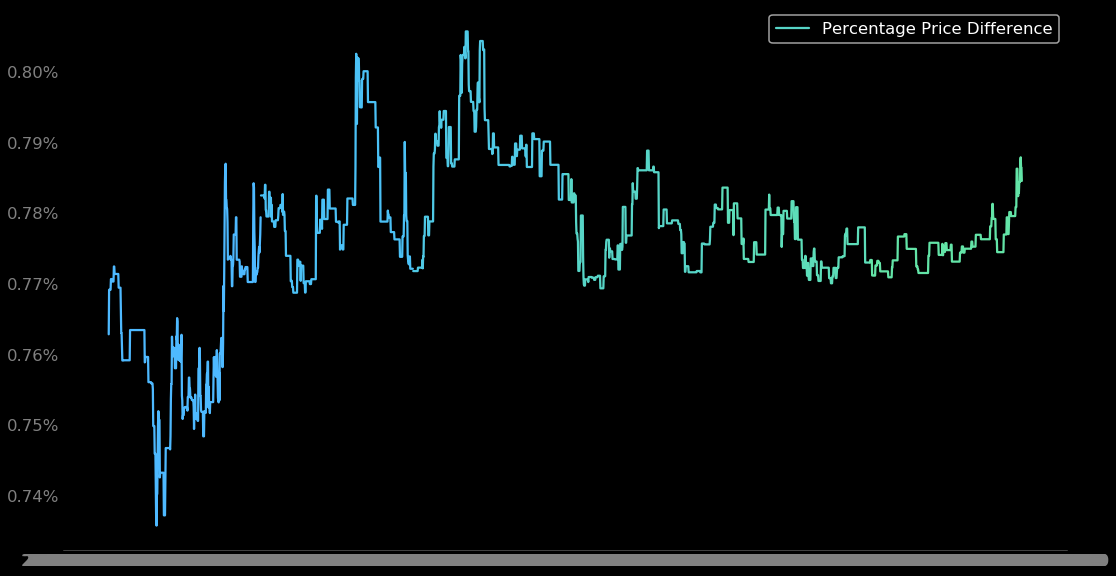

In [27]:
arb_viz('bitfinex_cbpro_dash_btc')

In [23]:
ALL_FEATURES = ['close_exchange_1','base_volume_exchange_1', 
                    'nan_ohlcv_exchange_1','volume_adi_exchange_1', 'volume_obv_exchange_1',
                    'volume_cmf_exchange_1', 'volume_fi_exchange_1','volume_em_exchange_1', 
                    'volume_vpt_exchange_1','volume_nvi_exchange_1', 'volatility_atr_exchange_1',
                    'volatility_bbhi_exchange_1','volatility_bbli_exchange_1', 
                    'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1',
                    'volatility_dchi_exchange_1','volatility_dcli_exchange_1',
                    'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 
                    'trend_adx_exchange_1', 'trend_adx_pos_exchange_1', 
                    'trend_adx_neg_exchange_1', 'trend_vortex_ind_pos_exchange_1', 
                    'trend_vortex_ind_neg_exchange_1', 'trend_vortex_diff_exchange_1', 
                    'trend_trix_exchange_1', 'trend_mass_index_exchange_1', 
                    'trend_cci_exchange_1', 'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1',
                    'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1',
                    'trend_aroon_down_exchange_1', 'trend_aroon_ind_exchange_1',
                    'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1',
                    'momentum_tsi_exchange_1', 'momentum_uo_exchange_1',
                    'momentum_stoch_signal_exchange_1', 'momentum_wr_exchange_1', 
                    'momentum_ao_exchange_1', 'others_dr_exchange_1', 'close_exchange_2',
                    'base_volume_exchange_2', 'nan_ohlcv_exchange_2',
                    'volume_adi_exchange_2', 'volume_obv_exchange_2',
                    'volume_cmf_exchange_2', 'volume_fi_exchange_2',
                    'volume_em_exchange_2', 'volume_vpt_exchange_2',
                    'volume_nvi_exchange_2', 'volatility_atr_exchange_2',
                    'volatility_bbhi_exchange_2', 'volatility_bbli_exchange_2',
                    'volatility_kchi_exchange_2', 'volatility_kcli_exchange_2',
                    'volatility_dchi_exchange_2', 'volatility_dcli_exchange_2',
                    'trend_macd_signal_exchange_2',
                    'trend_macd_diff_exchange_2', 'trend_adx_exchange_2',
                    'trend_adx_pos_exchange_2', 'trend_adx_neg_exchange_2',
                    'trend_vortex_ind_pos_exchange_2',
                    'trend_vortex_ind_neg_exchange_2',
                    'trend_vortex_diff_exchange_2', 'trend_trix_exchange_2',
                    'trend_mass_index_exchange_2', 'trend_cci_exchange_2',
                    'trend_dpo_exchange_2', 'trend_kst_sig_exchange_2',
                    'trend_kst_diff_exchange_2', 'trend_aroon_up_exchange_2',
                    'trend_aroon_down_exchange_2',
                    'trend_aroon_ind_exchange_2',
                    'momentum_rsi_exchange_2', 'momentum_mfi_exchange_2',
                    'momentum_tsi_exchange_2', 'momentum_uo_exchange_2',
                    'momentum_stoch_signal_exchange_2',
                    'momentum_wr_exchange_2', 'momentum_ao_exchange_2',
                    'others_dr_exchange_2', 'year', 'month', 'day',
                    'higher_closing_price', 'pct_higher', 
                    'arbitrage_opportunity', 'window_length']

In [24]:
print(ALL_FEATURES)

['close_exchange_1', 'base_volume_exchange_1', 'nan_ohlcv_exchange_1', 'volume_adi_exchange_1', 'volume_obv_exchange_1', 'volume_cmf_exchange_1', 'volume_fi_exchange_1', 'volume_em_exchange_1', 'volume_vpt_exchange_1', 'volume_nvi_exchange_1', 'volatility_atr_exchange_1', 'volatility_bbhi_exchange_1', 'volatility_bbli_exchange_1', 'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1', 'volatility_dchi_exchange_1', 'volatility_dcli_exchange_1', 'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 'trend_adx_exchange_1', 'trend_adx_pos_exchange_1', 'trend_adx_neg_exchange_1', 'trend_vortex_ind_pos_exchange_1', 'trend_vortex_ind_neg_exchange_1', 'trend_vortex_diff_exchange_1', 'trend_trix_exchange_1', 'trend_mass_index_exchange_1', 'trend_cci_exchange_1', 'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1', 'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1', 'trend_aroon_down_exchange_1', 'trend_aroon_ind_exchange_1', 'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1'

In [35]:
pd.read_csv('model_perf-2.csv')

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,kraken_bitfinex_bch_btc_lr,kraken_bitfinex_bch_btc,lr,{},1.000000,NaN,NaN,NaN,0,0,0,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN
1,kraken_gemini_eth_btc_lr,kraken_gemini_eth_btc,lr,{},0.996209,-0.20,-0.15,0.000760,0,0,0,0.000000,0.999240,0.000000,0.000000,0.996965,0.000000,0.000000,0.998101,0.000000
2,cbpro_gemini_bch_btc_lr,cbpro_gemini_bch_btc,lr,{},0.706507,2.55,2.41,0.288186,32,59,91,0.470588,0.711814,0.776316,0.129032,0.987654,0.127983,0.202532,0.827348,0.219739
3,gemini_hitbtc_eth_btc_lr,gemini_hitbtc_eth_btc,lr,{},0.978059,NaN,NaN,0.021941,0,0,0,0.000000,0.978059,0.000000,0.000000,1.000000,0.000000,0.000000,0.988908,0.000000
4,bitfinex_kraken_etc_usd_lr,bitfinex_kraken_etc_usd,lr,{},0.022197,-0.24,-0.28,NaN,0,77,77,0.000000,0.000000,0.022197,0.000000,0.000000,1.000000,0.000000,0.000000,0.043429
5,cbpro_hitbtc_eos_btc_lr,cbpro_hitbtc_eos_btc,lr,{},0.999261,-0.61,-0.59,0.000000,0,0,0,0.000000,1.000000,NaN,0.000000,0.999261,NaN,0.000000,0.999631,NaN
6,kraken_cbpro_dash_btc_lr,kraken_cbpro_dash_btc,lr,{},0.002414,-0.39,-0.41,NaN,6,0,6,0.002414,0.000000,0.000000,1.000000,0.000000,0.000000,0.004817,0.000000,0.000000
7,bitfinex_gemini_bch_usd_lr,bitfinex_gemini_bch_usd,lr,{},0.995319,NaN,NaN,0.004681,0,0,0,0.000000,0.995319,NaN,0.000000,1.000000,NaN,0.000000,0.997654,NaN
8,cbpro_bitfinex_eth_usd_lr,cbpro_bitfinex_eth_usd,lr,{},0.168127,0.13,-0.22,0.000000,0,11030,11030,0.000000,1.000000,0.168115,0.000000,0.000018,1.000000,0.000000,0.000037,0.287839
9,gemini_hitbtc_ltc_btc_lr,gemini_hitbtc_ltc_btc,lr,{},0.867197,NaN,NaN,0.132803,0,0,0,0.000000,0.867197,0.000000,0.000000,1.000000,0.000000,0.000000,0.928876,0.000000
